# Forecasting Australia's GDP using ARIMA

Data source: https://data.worldbank.org/indicator/NY.GDP.MKTP.CD?locations=AU&page=


In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.tseries.offsets import DateOffset

import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\ryana\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#Get data
df = pd.read_excel('EconomicDataV2.xlsx')
df = df[['Year', 'Australia_GDP_USD']]
df.head()

,Year,Australia_GDP_USD
0,31/12/1960,1.857319e+10
1,31/12/1961,1.964834e+10
2,31/12/1962,1.988801e+10
3,31/12/1963,2.150185e+10
4,31/12/1964,2.375854e+10


In [3]:
# Ensure Year column is an actual date and use as index
df['Year'] = pd.to_datetime(df['Year'])
df.set_index('Year', inplace=True)

In [4]:
#Review statistics
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Australia_GDP_USD,58.0,4.173994e+11,4.544778e+11,1.857319e+10,9.089369e+10,2.675088e+11,4.583630e+11,1.573697e+12


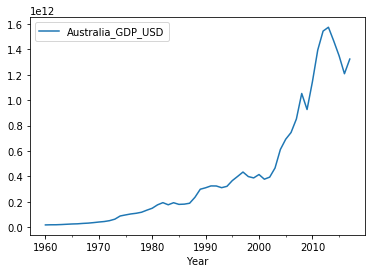

In [5]:
df.plot()

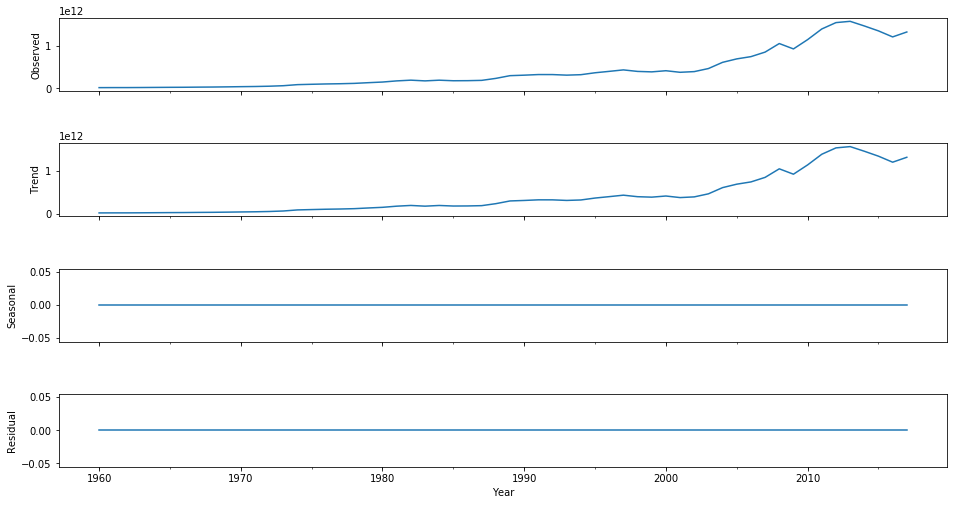

In [6]:
# Review trend and seasonality
time_series = df['Australia_GDP_USD']

decomp = seasonal_decompose(time_series)
fig = decomp.plot()
fig.set_size_inches(15,8)

In [7]:
def adf_check(time_series):
    
    result = adfuller(time_series)
    print("Augmented Dicky-Fuller Test")
    labels = ['ADF Test Statistic', 'p-value', '# of lags', 'Num of Observations used']
    
    for value, label in zip(result, labels):
        print(label+ " : "+str(value))
        
    if result[1] <= 0.05:
        print('reject null hypothesis - data has no unit root and is stationary')
    
    else:
        print('Fail to reject null hypothesis - data has no unit root, it is non-stationary')


In [8]:
adf_check(df['Australia_GDP_USD'])

Augmented Dicky-Fuller Test
ADF Test Statistic : 2.815852180893708
p-value : 1.0
# of lags : 10
Num of Observations used : 47
Fail to reject null hypothesis - data has no unit root, it is non-stationary


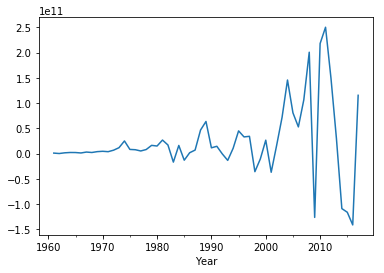

In [9]:
df['First Difference'] = df['Australia_GDP_USD'] - df['Australia_GDP_USD'].shift(1)
df['First Difference'].plot()

In [10]:
# Check if first difference is stationary
adf_check(df['First Difference'].dropna())

Augmented Dicky-Fuller Test
ADF Test Statistic : -5.236559185532907
p-value : 7.400350723181162e-06
# of lags : 0
Num of Observations used : 56
reject null hypothesis - data has no unit root and is stationary


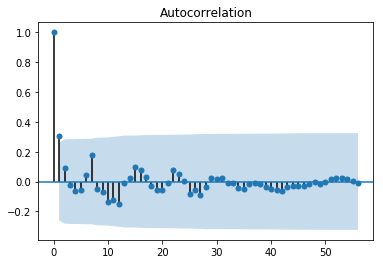

In [11]:
#Graph autocorelation
fig_first = plot_acf(df['First Difference'].dropna())

In [12]:
model = sm.tsa.statespace.SARIMAX(df['Australia_GDP_USD'], enforce_stationarity = False, order = (2,1,0))
results = model.fit()
print(results.summary())

                           Statespace Model Results                           
Dep. Variable:      Australia_GDP_USD   No. Observations:                   58
Model:               SARIMAX(2, 1, 0)   Log Likelihood               -1451.534
Date:                Wed, 13 Mar 2019   AIC                           2909.067
Time:                        18:23:55   BIC                           2915.248
Sample:                    12-31-1960   HQIC                          2911.475
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3634      0.066      5.473      0.000       0.233       0.494
ar.L2          0.0336      0.071      0.470      0.638      -0.106       0.173
sigma2      4.908e+21   4.76e-24   1.03e+45      0.0

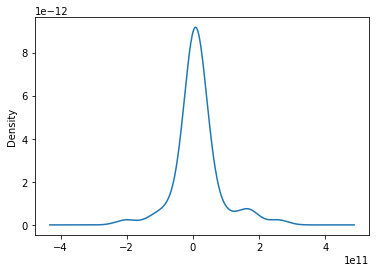

In [13]:
# Kernel Density Estimation Plot
results.resid.plot(kind='kde')

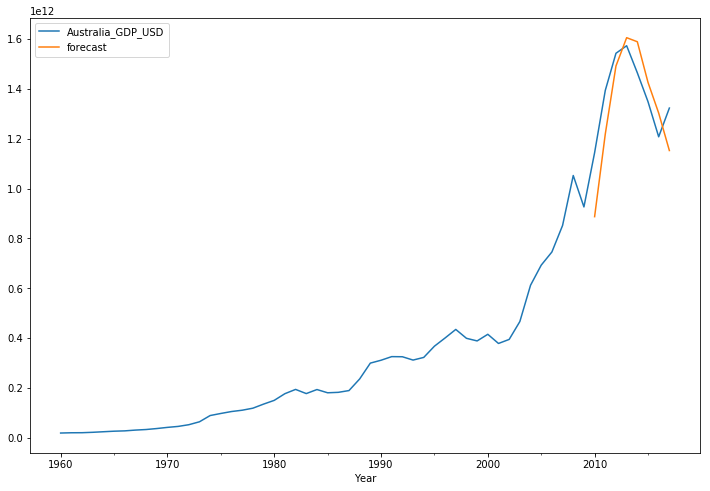

In [14]:
#Check forecast accuracy against actuals
df['forecast'] = results.predict(start = 50, end = 58)
df[['Australia_GDP_USD', 'forecast']].plot(figsize=(12,8))

Forecast 5 years into the future:

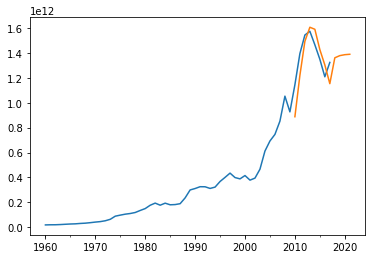

In [15]:
# Append future dates onto existing dataframe
future_dates = [df.index[-1] + DateOffset(years=x) for x in range(1,5)]
future_df = pd.DataFrame(index=future_dates, columns = df.columns)
final_df = pd.concat([df, future_df])

# Predict 5 years into the future and plot
final_df['forecast'] = results.predict(start = 50, end = 63)
final_df['Australia_GDP_USD'].plot()
final_df['forecast'].plot()